In [58]:
def categorical_crossentropy(t,y):
    return np.mean(-t*np.log(y+0.0001))

In [59]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [60]:
def softmax(x):
    c = np.max(x,axis=1).reshape(-1,1)
    x = x-c
    return np.exp(x)/np.sum(np.exp(x),axis=1).reshape(-1,1)

In [61]:
import numpy as np
class Relu:
    def __init__(self):
        self.mask = None
    def forward(self,x):
        self.mask = (x <=0)
        out = x.copy()
        out[self.mask] = 0
        return out
    def backward(self,dout):
        dout[self.mask] = 0
        dx = dout
        return dx
        
class Sigmoid:
    def __init__(self):
        self.out = None
    
    def forward(self,x):
        out = sigmoid(x)
        self.out = out
        return out
    
    def backward(self,dout):
        dx = ((1-self.out)*self.out)*dout
        return dx

class Affine:
    def __init__(self,W,b):
        self.W = W
        self.b = b
        self.x = None
        self.origin_shape = None
        self.dW = None
        self.db = None
    
    def forward(self,x):
        self.origin_shape = x.shape
        self.x = x
        out = np.dot(x,self.W) + self.b
        return out
    
    def backward(self,dout):
        dx = np.dot(dout,self.W.T)
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout,axis=0)
        dx = dx.reshape(self.origin_shape)
        return dx

class Loss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self,t,y):
        self.y = softmax(y)
        self.t = t
        self.loss = categorical_crossentropy(self.t, self.y)
        return self.loss
    
    def backward(self,dout=1):
        dx = (self.y - self.t)*dout
        return dx

In [62]:
class Layers:
    def __init__(self):
        self.layers = {}
        
    def add(self,x1,x2,activation):
        activation_dict = {
            'sigmoid':Sigmoid,
            'relu':Relu,
            'softmax':Loss
        }
        w = np.random.randn(x1,x2)
        b = np.zeros(x2)
        activation_layer = 'activation'+str((int(len(self.layers)/2+1))) 
        Affine_layer = 'Affine'+str((int(len(self.layers)/2+1)))
        self.layers[Affine_layer] = Affine(w,b)
        self.layers[activation_layer] = activation_dict[activation]()
        
    
    def predict(self,x):
        out = x.copy()
        ind = 1 
        layer_len = len(self.layers)
        for key, layer in self.layers.items():
            if ind < layer_len :
                out = layer.forward(out)
            ind += 1
        return out
            
    
    def loss(self,x,t):
        y = self.predict(x)
        out = list(self.layers.values())[-1].forward(t,y)
        return out
    
    def accuracy(self,x,t):
        y = self.predict(x)
        y = np.argmax(y,axis=1)
        t = np.argmax(t,axis=1)
        self.acc = np.sum(y==t)/t.size
        return self.acc
    
    def gradient(self,x,t):
        self.loss(x,t)
        lr = 1e-4
        dout = 1
        dout = list(self.layers.values())[-1].backward(dout)
        layers = list(self.layers.values())[::-1][1:]
        self.layers_key = list(self.layers.keys())[::-1][1:]
        for layer in layers:
            dout = layer.backward(dout)
        self.grads = {}
        for layer_key in self.layers_key:
            if 'Affine' in layer_key:
                self.grads[layer_key] = [self.layers[layer_key].dW, self.layers[layer_key].db]
        for layer_key in self.layers_key:
            if 'Affine' in layer_key:
                self.layers[layer_key].W -= lr*self.grads[layer_key][0]
                self.layers[layer_key].b -= lr*self.grads[layer_key][1]
        result = self.loss(x,t)       
        return result
    
    def fit(self,x,t,epochs,lr):
        self.lr = lr
        self.history = {}
        accuracy = []
        loss = []
        for epoch in range(epochs):
            self.gradient(x,t)
            loss.append(self.err)
            accuracy.append(self.accuracy(x,t))
            if epoch % 100 == 0:
                print(f'loss : {self.err} === accuracy : {self.accuracy(x,t)}')
        self.history['accuracy'] = accuracy
        self.history['loss'] = loss
                

In [6]:
# 필요한 모듈 호출
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# 텐서플로우 모듈
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import plot_model, to_categorical
from keras.datasets import mnist

In [47]:
# 데이터 정리
(x_train_full, y_train_full),(x_test, y_test) = mnist.load_data()
x_train, x_val, y_train, y_val = \
    train_test_split(x_train_full, y_train_full, test_size= .2, random_state=42)

In [48]:
# 분배 및 차원 확인
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 28, 28)
(12000, 28, 28)
(48000,)
(12000,)


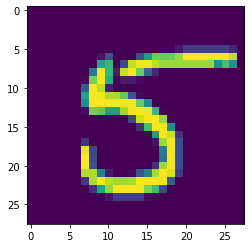

target = 5


In [49]:
# 데이터 타입 확인
plt.imshow(x_train[0])
plt.show()
print('target =', y_train[0])

In [50]:
# x 데이터 reshape
x_train_reshape = x_train.reshape(-1,784)
x_val_reshape = x_val.reshape(-1, 784)
x_test_reshape = x_test.reshape(-1, 784)

In [51]:
# y 데이터 종류
# 연속형
# 바이너리 범주형(둘중하나) -> 0, 1 변경
# 카테고리컬 범주형(2개이상) -> one_hot 변경

# y 데이터 확인 -> 카테고리컬 범주형 -> one_hot
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [52]:
# y 데이터 one_hot 변환
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
y_test_one_hot = to_categorical(y_test)

In [64]:
# 모델생성
model1 = Sequential()
l1 = Dense(1024, activation ='relu', input_dim =784)
l2 = Dense(512, activation ='sigmoid')
out = Dense(10, activation='softmax')
model1.add(l1)
model1.add(l2)
model1.add(out)

In [65]:
# 모델설정
optimizer = 'sgd'
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model1.compile(
    optimizer= optimizer,
    loss= loss,
    metrics = metrics
)

In [69]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              803840    
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 1,333,770
Trainable params: 1,333,770
Non-trainable params: 0
_________________________________________________________________


In [67]:
# 모델 학습
model1.fit(
    x_train_reshape,
    y_train_one_hot,
    epochs = 10,
    validation_data =(x_val_reshape, y_val_one_hot)
)

Epoch 1/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4139 - accuracy: 0.8889 - val_loss: 0.2454 - val_accuracy: 0.9312
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2092 - accuracy: 0.9400 - val_loss: 0.1796 - val_accuracy: 0.9487
Epoch 3/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1554 - accuracy: 0.9557 - val_loss: 0.1495 - val_accuracy: 0.9567
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1233 - accuracy: 0.9643 - val_loss: 0.1346 - val_accuracy: 0.9611
Epoch 5/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0994 - accuracy: 0.9712 - val_loss: 0.1190 - val_accuracy: 0.9657
Epoch 6/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0832 - accuracy: 0.9760 - val_loss: 0.1080 - val_accuracy: 0.9682
Epoch 7/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0695 - accuracy: 0.9804 - val_loss: 0.1000 - val_accuracy:

In [70]:
# test 정확도 검증
model1.evaluate(x_test_reshape, y_test_one_hot)

313/313 [==============================] - 1s 2ms/step - loss: 0.0816 - accuracy: 0.9748


[0.08161752671003342, 0.9747999906539917]

In [77]:
np.sum(np.argmax(model1.predict(x_test_reshape),axis=1) == np.argmax(y_test_one_hot,axis=1)) / len(y_test_one_hot)

0.9748

In [111]:
## 활용
def mnist_test(size):
    index = np.random.choice(np.arange(len(x_test_reshape)),size,replace=False)
    size = size
    score = 0

    for i in index:
        plt.imshow(x_test_reshape[i].reshape(28,28))
        predict = np.argmax(model1.predict(x_test_reshape[[i]]))
        real = np.argmax(y_test_one_hot[i])
        if predict == real:
            result = '정답'
            score += 1
        else :
            result = '오답'
        plt.show()
        print('실제값=',real)
        print('예측값=',predict)
        print(result)
    score_per = (score/size)*100
    print('=======================================')
    print('총 정답 갯수=',score)
    print(f'예측률= {score_per}%')
    print('=======================================')

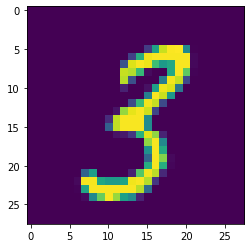

실제값= 3
예측값= 3
정답


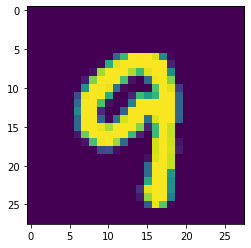

실제값= 9
예측값= 9
정답


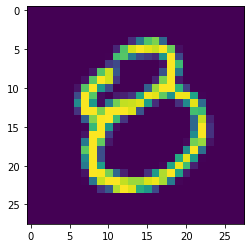

실제값= 8
예측값= 0
오답


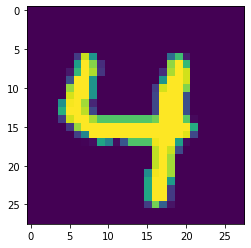

실제값= 4
예측값= 4
정답


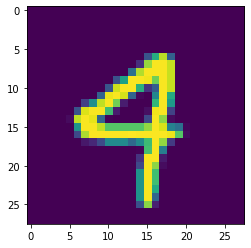

실제값= 4
예측값= 4
정답
총 정답 갯수= 4
예측률= 80.0%


In [114]:
mnist_test(5)

In [ ]:
model2 = Sequential()
model2.compile()

In [ ]:
model1.compile(
    optimizer= optimizer,
    loss= loss,
    metrics = metrics
)